In [1]:
import pandas as pd
import numpy as np
import pickle
from pprint import pprint
import matplotlib.pyplot as plt
from gensim.corpora import Dictionary, MmCorpus
from gensim.models import LdaModel
from gensim.test.utils import datapath

/usr/local/lib/python3.9/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
# load data
dictionary = Dictionary.load("data/dictionary.pkl")
temp_file = open("data/train.pkl", "rb")
train = pickle.load(temp_file)
train.reset_index(drop=True, inplace=True)
temp_file.close()
train_reviews = train["tokens"].tolist()
train_corpus = MmCorpus("data/train_corpus.mm")

### LDA

In [3]:
# load 20 topics
lda = LdaModel.load(datapath("lda_20"))

In [4]:
# learned topic proportion prior
lda.alpha

array([0.05021863, 0.05223789, 0.06901904, 0.14681493, 0.03687393,
       0.0456535 , 0.08080044, 0.07867136, 0.04449197, 0.05856434,
       0.03990827, 0.05818802, 0.07114197, 0.03763724, 0.07104202,
       0.05228801, 0.07346187, 0.05563435, 0.04022862, 0.0654724 ],
      dtype=float32)

In [5]:
# track topic proportions and counts by genre and rating
genre_props = np.zeros((3,20))
genre_counts = np.zeros((3,20))
rating_props = np.zeros((6,20))
rating_counts = np.zeros((6,20))

genre_dict = {
    "fantasy": 0,
    "history": 1,
    "mystery": 2
}

# and find representative documents for each topic (max prop)
topic_doc_dict = {
    0:[], 1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[], 8:[], 9:[],
    10:[], 11:[], 12:[], 13:[], 14:[], 15:[], 16:[], 17:[], 18:[], 19:[],
}

# gather above info for each doc
for i, doc in enumerate(train_corpus):
    doc_genre = train.loc[i,"genre"]
    doc_rating = train.loc[i,"rating"]
    topic_props = lda.get_document_topics(doc, minimum_probability=0.01)
    doc_max_prop = (0,0)
    for top in topic_props:
        genre_props[genre_dict[doc_genre],top[0]] += top[1]
        genre_counts[genre_dict[doc_genre],top[0]] += 1
        rating_props[doc_rating,top[0]] += top[1]
        rating_counts[doc_rating,top[0]] += 1
        # track topic with max proportion in document
        if top[1] > doc_max_prop[1]:
            doc_max_prop = top
    # add doc to dict for topic of max proportion
    topic_doc_dict[doc_max_prop[0]].append((i,doc_max_prop[1]))

In [6]:
# average topics per review
genre_counts.sum()/len(train_corpus)

4.836711424863239

In [7]:
# average topics per review by genre
genre_counts.sum(1)/train.groupby("genre").count()["book_id"].to_numpy()

array([4.80868769, 4.88777494, 4.83146014])

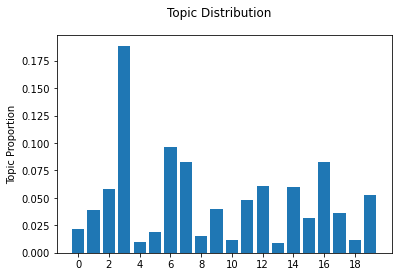

In [8]:
# overall topic distribution
topic_props = genre_props.sum(0)/len(train_corpus)
fig, ax = plt.subplots()
fig.suptitle("Topic Distribution")
ax.bar(np.arange(20),topic_props)
ax.set_xticks(np.arange(0,20,2))
ax.set_ylabel("Topic Proportion")
plt.show()

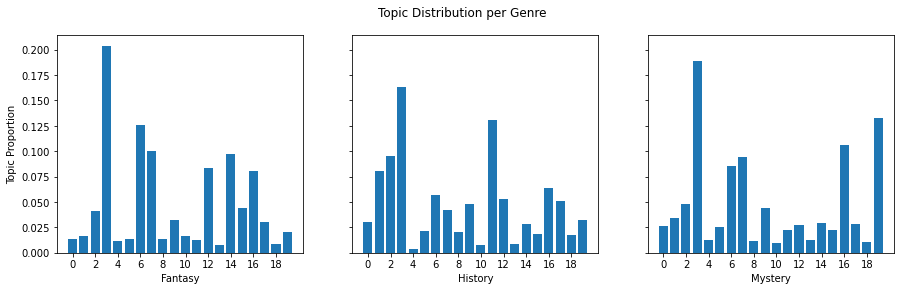

In [9]:
# per genre topic distribution
per_genre_props = np.divide(genre_props,train.groupby("genre").count()["book_id"].to_numpy()[:,np.newaxis])
fig, ax = plt.subplots(1,3,sharey=True,figsize=(15,4))
fig.suptitle("Topic Distribution per Genre")
ax[0].set_xlabel("Fantasy")
ax[0].bar(np.arange(20),per_genre_props[0])
ax[0].set_xticks(np.arange(0,20,2))
ax[0].set_ylabel("Topic Proportion")
ax[1].set_xlabel("History")
ax[1].bar(np.arange(20),per_genre_props[1])
ax[1].set_xticks(np.arange(0,20,2))
ax[2].set_xlabel("Mystery")
ax[2].bar(np.arange(20),per_genre_props[2])
ax[2].set_xticks(np.arange(0,20,2))
plt.show()

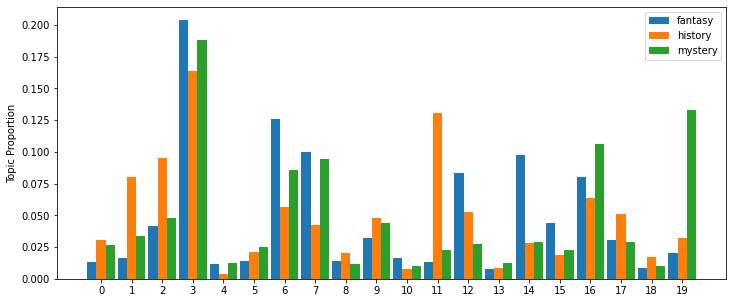

In [30]:
fig, ax = plt.subplots(figsize=(12,5))
width = 0.3
ax.bar(np.arange(20)-width,per_genre_props[0],width,label="fantasy")
ax.bar(np.arange(20),per_genre_props[1],width,label="history")
ax.bar(np.arange(20)+width,per_genre_props[2],width,label="mystery")
ax.set_ylabel("Topic Proportion")
plt.xticks(np.arange(20))
plt.legend()
plt.show()

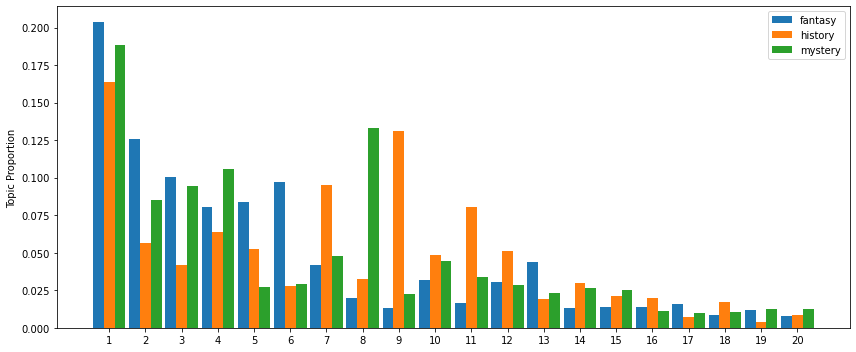

In [31]:
# format for paper - NOTE changing topic numbers, make sure other references match
fig, ax = plt.subplots(figsize=(12,5))
width = 0.3
ax.bar(np.arange(20)-width,per_genre_props[0][np.argsort(topic_props)[::-1]],width,label="fantasy")
ax.bar(np.arange(20),per_genre_props[1][np.argsort(topic_props)[::-1]],width,label="history")
ax.bar(np.arange(20)+width,per_genre_props[2][np.argsort(topic_props)[::-1]],width,label="mystery")
ax.set_ylabel("Topic Proportion")
plt.xticks(np.arange(20), labels=np.arange(20)+1)
plt.legend()
plt.tight_layout()
plt.savefig("LDA_topicbygenre.png")

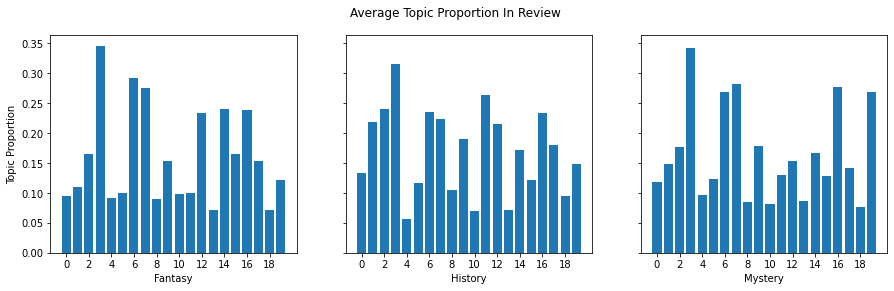

In [11]:
# avg topic proportion when present in a review (so shouldn't sum to 1)
genre_avg_props = np.divide(genre_props,genre_counts,out=np.zeros((3,20)),where=genre_counts!=0)
fig, ax = plt.subplots(1,3,sharey=True,figsize=(15,4))
fig.suptitle("Average Topic Proportion In Review")
ax[0].set_xlabel("Fantasy")
ax[0].bar(np.arange(20),genre_avg_props[0])
ax[0].set_xticks(np.arange(0,20,2))
ax[0].set_ylabel("Topic Proportion")
ax[1].set_xlabel("History")
ax[1].bar(np.arange(20),genre_avg_props[1])
ax[1].set_xticks(np.arange(0,20,2))
ax[2].set_xlabel("Mystery")
ax[2].bar(np.arange(20),genre_avg_props[2])
ax[2].set_xticks(np.arange(0,20,2))
plt.show()

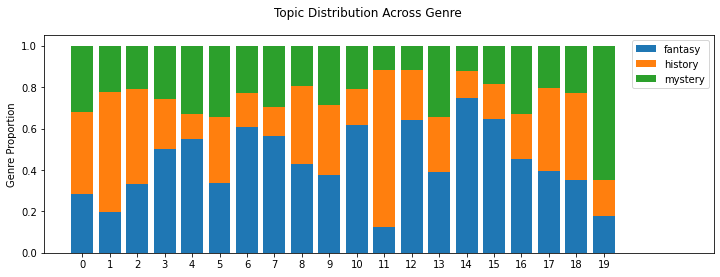

In [12]:
# topic distribution across genre
topic_genre_props = pd.DataFrame((genre_props/genre_props.sum(0)).T,columns=["fantasy","history","mystery"])
fig, ax = plt.subplots(figsize=(12,4))
fig.suptitle("Topic Distribution Across Genre")
ax.bar(np.arange(20),topic_genre_props["fantasy"],label="fantasy")
ax.bar(np.arange(20),topic_genre_props["history"],label="history",bottom=topic_genre_props["fantasy"])
ax.bar(np.arange(20),topic_genre_props["mystery"],label="mystery",bottom=topic_genre_props["fantasy"]+topic_genre_props["history"])
ax.set_xticks(np.arange(20))
ax.set_xlim(None,23)
ax.set_ylabel("Genre Proportion")
ax.legend()
plt.show()

In [13]:
pprint(lda.print_topics(num_words=20))

[(0,
  '0.009*"new" + 0.008*"life" + 0.006*"year" + 0.006*"time" + 0.006*"york" + '
  '0.005*"new_york" + 0.004*"find" + 0.004*"family" + 0.004*"like" + '
  '0.004*"movie" + 0.004*"city" + 0.004*"novel" + 0.003*"woman" + 0.003*"film" '
  '+ 0.003*"friend" + 0.003*"also" + 0.003*"art" + 0.003*"home" + 0.003*"old" '
  '+ 0.003*"character"'),
 (1,
  '0.021*"life" + 0.014*"year" + 0.010*"child" + 0.009*"family" + '
  '0.008*"woman" + 0.008*"people" + 0.007*"young" + 0.007*"war" + 0.007*"girl" '
  '+ 0.006*"time" + 0.006*"old" + 0.005*"mother" + 0.004*"place" + '
  '0.004*"home" + 0.004*"two" + 0.004*"father" + 0.004*"back" + 0.004*"day" + '
  '0.004*"many" + 0.004*"u"'),
 (2,
  '0.006*"world" + 0.006*"time" + 0.005*"people" + 0.005*"would" + '
  '0.004*"also" + 0.004*"even" + 0.004*"much" + 0.004*"reader" + 0.004*"way" + '
  '0.004*"well" + 0.003*"make" + 0.003*"war" + 0.003*"work" + 0.003*"many" + '
  '0.003*"good" + 0.003*"point" + 0.003*"human" + 0.003*"like" + 0.003*"take" '
  '+ 0.003

In [14]:
# representative reviews for each topic
for i in range(20):
    print("\nTOPIC ",i)
    topic_doc_dict[i].sort(key = lambda x: x[1], reverse=True)
    for j in range(3):
        if len(topic_doc_dict[i])>j:
            print(topic_doc_dict[i][j])
            print(train.loc[topic_doc_dict[i][j][0],"review_text"])


TOPIC  0
(77159, 0.9633966)
Classic. This story has the most descriptive and riviting scenes, you can practically hear the trees sway in the wind, see the kids creeping through the catacombs, and smell the fall crisp air. Even years later I can still remember these scenes. 
 A simple story of a bunch of kids looking for their lost friend is told in such a creative and page-turning manner!
(13774, 0.9550165)
I will bypass writing a review in order to make an even more important announcement: this entire book was read in the bath. Six months of Sunday night baths. Six hundred pages worth of warm baths. Warm, warm baths. In water.
(65854, 0.9273635)
This is the follow-up memoir to "When I was Puerto Rican". This memoir covers Santiago's teenaged years and her experiences at the performing arts high school and trying to discover who she is and what she wants to do with her life.

TOPIC  1
(11788, 0.97702444)
The book Dairy of Anne Frank is about a girl named Anne who lived during World Wa

In [15]:
def plot_difference(mdiff, title="", annotation=None):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(figsize=(18, 14))
    data = ax.imshow(mdiff, cmap='RdBu_r', origin='lower')
    plt.title(title)
    plt.colorbar(data)

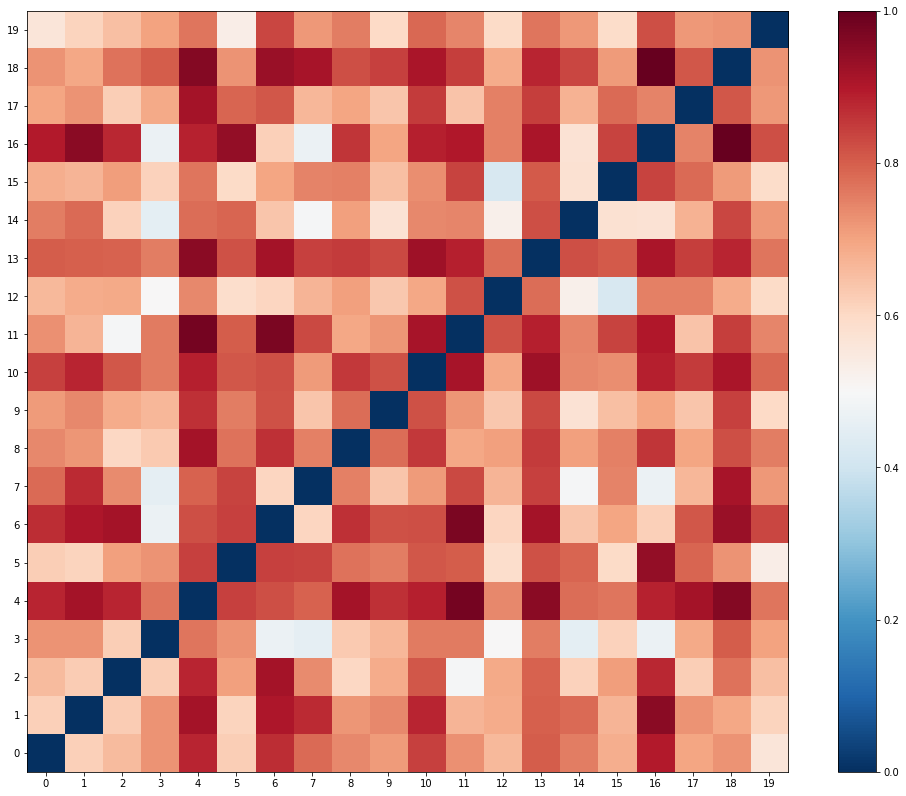

In [23]:
lda = LdaModel.load(datapath("lda_20"))
mdiff, annotation = lda.diff(lda, "jensen_shannon")
plot_difference(mdiff)
plt.xticks(np.arange(20))
plt.yticks(np.arange(20))
plt.show()